In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model

### Read the train/validation and test data

In [2]:
train_val_df = pd.read_csv('xeno_canto_train_val.csv')
test_df = pd.read_csv('xeno_canto_test.csv')

In [3]:
train_val_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,0,3.0,44100,White-bellied Tody-Tyrant
1,1,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,3,6.0,44100,White-bellied Tody-Tyrant
2,2,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,6,9.0,44100,White-bellied Tody-Tyrant
3,3,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,9,12.0,44100,White-bellied Tody-Tyrant
4,4,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,12,15.0,44100,White-bellied Tody-Tyrant


In [4]:
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,0,3.0,44100,White-bellied Tody-Tyrant
1,1,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,3,6.0,44100,White-bellied Tody-Tyrant
2,2,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,6,9.0,44100,White-bellied Tody-Tyrant
3,3,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,9,12.0,44100,White-bellied Tody-Tyrant
4,4,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,12,15.0,44100,White-bellied Tody-Tyrant


### Check counts of the different classes in both the dataframes

In [5]:
train_val_df['MANUAL ID'].value_counts()

White-throated Toucan        3776
Red-eyed Vireo               1886
Eastern Kingbird             1403
White-bellied Tody-Tyrant    1018
None                          951
Ihering's Antwren             295
Great-billed Hermit           237
Chivi Vireo                   234
Philadelphia Vireo             60
Scissor-tailed Flycatcher      58
Black-and-white Warbler        50
Creamy-bellied Thrush          50
Wood Thrush                    41
Yellow-throated Toucan         28
Noronha Vireo                  26
Brown Bullfinch                26
Yellow-bellied Flycatcher      19
Bamboo Antshrike               19
Long-billed Hermit             17
Water Rail                     15
Philippine Woodpecker          12
Brown Violetear                11
Yellow-green Vireo             11
Striated Antbird               11
Blue-backed Manakin            11
Channel-billed Toucan           9
White-throated Spadebill        8
Brown-headed Cowbird            8
Mountain Scops-Owl              6
White-browed T

In [6]:
test_df['MANUAL ID'].value_counts()

White-throated Toucan        107
Ihering's Antwren            102
Red-eyed Vireo                98
Brassy-breasted Tanager       91
Eastern Kingbird              85
White-bellied Tody-Tyrant     83
None                          66
Charming Hummingbird          26
Bluish-slate Antshrike        25
Chivi Vireo                    4
Name: MANUAL ID, dtype: int64

### Changing species' names to a simpler version for convenience

In [7]:
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = 'Toucan'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Flycatcher'), 'MANUAL ID'] = 'Flycatcher'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Thrush'), 'MANUAL ID'] = 'Thrush'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = 'Vireo'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = 'Antwren'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = 'Tanager'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = 'Kingbird'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = 'Tody-Tyrant'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = 'Hummingbird'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = 'Antshrike'

### Remove rows from dataframes which are not the species of our interest

In [8]:
classes = ['Antwren', 'Antshrike', 'Toucan', 'Vireo', 'Kingbird', 'Tody-Tyrant', 'None']
for i, row in train_val_df.iterrows():
    if(row['MANUAL ID'] not in classes):
        train_val_df.drop(i, inplace=True)
for i, row in test_df.iterrows():
    if(row['MANUAL ID'] not in classes):
        test_df.drop(i, inplace=True)
print('Classwise Counts for train/val data:')
print(train_val_df['MANUAL ID'].value_counts())
print('\nClasswise  Counts for test data:')
print(test_df['MANUAL ID'].value_counts())

Classwise Counts for train/val data:
Toucan         3813
Vireo          2217
Kingbird       1403
Tody-Tyrant    1018
None            951
Antwren         295
Antshrike        19
Name: MANUAL ID, dtype: int64

Classwise  Counts for test data:
Toucan         107
Antwren        102
Vireo          102
Kingbird        85
Tody-Tyrant     83
None            66
Antshrike       25
Name: MANUAL ID, dtype: int64


### Convert the train/val and test data to one-hot representations of the classes

In [9]:
# Train/val
one_hot_labels, train_classes = categorical_to_one_hot(train_val_df[['MANUAL ID']].values)
train_val_df = pd.DataFrame(index=train_val_df['file'],data=one_hot_labels,columns=train_classes)

# Test
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

### Split the trainining/validation dataframe into training and validation sets

In [10]:
train_df, valid_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [11]:
print("Number of training examples : ", train_df.shape[0])
print("Number of validation examples : ", valid_df.shape[0])
print("Number of test examples : ", test_df.shape[0])

Number of training examples :  7772
Number of validation examples :  1944
Number of test examples :  570


### Prepare the training and validation set for the CNN model

In [12]:
train_dataset = CnnPreprocessor(df=train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset = CnnPreprocessor(df=valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

### Create the Resnet-18 Multiclass model and train it

In [13]:
model = cnn.Resnet18Multiclass(train_classes)

created PytorchModel model object with 7 classes


In [14]:
model.sampler = 'imbalanced'
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./multilabel_train_seven_classes_xeno_canto/',
    epochs=10,
    batch_size=32,
    save_interval=100,
    num_workers=2
)

Epoch: 0 [batch 0/243 (0.00%)] 
	Jacc: 0.147 Hamm: 0.830 DistLoss: 30.046
Epoch: 0 [batch 10/243 (4.12%)] 
	Jacc: 0.000 Hamm: 0.143 DistLoss: 23.617
Epoch: 0 [batch 20/243 (8.23%)] 
	Jacc: 0.146 Hamm: 0.129 DistLoss: 20.766
Epoch: 0 [batch 30/243 (12.35%)] 
	Jacc: 0.488 Hamm: 0.080 DistLoss: 17.922
Epoch: 0 [batch 40/243 (16.46%)] 
	Jacc: 0.474 Hamm: 0.080 DistLoss: 15.772
Epoch: 0 [batch 50/243 (20.58%)] 
	Jacc: 0.681 Hamm: 0.045 DistLoss: 14.166
Epoch: 0 [batch 60/243 (24.69%)] 
	Jacc: 0.518 Hamm: 0.067 DistLoss: 12.872
Epoch: 0 [batch 70/243 (28.81%)] 
	Jacc: 0.392 Hamm: 0.098 DistLoss: 11.916
Epoch: 0 [batch 80/243 (32.92%)] 
	Jacc: 0.836 Hamm: 0.027 DistLoss: 11.034
Epoch: 0 [batch 90/243 (37.04%)] 
	Jacc: 0.843 Hamm: 0.036 DistLoss: 10.302
Epoch: 0 [batch 100/243 (41.15%)] 
	Jacc: 0.875 Hamm: 0.022 DistLoss: 9.676
Epoch: 0 [batch 110/243 (45.27%)] 
	Jacc: 0.896 Hamm: 0.018 DistLoss: 9.152
Epoch: 0 [batch 120/243 (49.38%)] 
	Jacc: 0.712 Hamm: 0.045 DistLoss: 8.687
Epoch: 0 [batch 

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 512 is greater than input length  = 468, using nperseg = 468
  .format(nperseg, input_length))


Epoch: 2 [batch 220/243 (90.53%)] 
	Jacc: 0.936 Hamm: 0.009 DistLoss: 1.862
Epoch: 2 [batch 230/243 (94.65%)] 
	Jacc: 0.909 Hamm: 0.022 DistLoss: 1.841
Epoch: 2 [batch 240/243 (98.77%)] 
	Jacc: 0.859 Hamm: 0.022 DistLoss: 1.846

Validation.
(1944, 7)
	 Precision: 0.8637273011050473
	 Recall: 0.9334661722531342
	 F1: 0.8853958119283325
Updating best model
Epoch: 3 [batch 0/243 (0.00%)] 
	Jacc: 0.912 Hamm: 0.013 DistLoss: 1.267
Epoch: 3 [batch 10/243 (4.12%)] 
	Jacc: 0.893 Hamm: 0.018 DistLoss: 1.410
Epoch: 3 [batch 20/243 (8.23%)] 
	Jacc: 0.852 Hamm: 0.027 DistLoss: 1.931
Epoch: 3 [batch 30/243 (12.35%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 1.709
Epoch: 3 [batch 40/243 (16.46%)] 
	Jacc: 0.781 Hamm: 0.036 DistLoss: 1.639
Epoch: 3 [batch 50/243 (20.58%)] 
	Jacc: 0.840 Hamm: 0.022 DistLoss: 1.644
Epoch: 3 [batch 60/243 (24.69%)] 
	Jacc: 0.863 Hamm: 0.018 DistLoss: 1.628
Epoch: 3 [batch 70/243 (28.81%)] 
	Jacc: 0.902 Hamm: 0.018 DistLoss: 1.665
Epoch: 3 [batch 80/243 (32.92%)] 
	Jacc: 1.000 

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 160/243 (65.84%)] 
	Jacc: 0.905 Hamm: 0.013 DistLoss: 1.087
Epoch: 4 [batch 170/243 (69.96%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 1.061
Epoch: 4 [batch 180/243 (74.07%)] 
	Jacc: 0.943 Hamm: 0.009 DistLoss: 1.053
Epoch: 4 [batch 190/243 (78.19%)] 
	Jacc: 0.837 Hamm: 0.027 DistLoss: 1.049
Epoch: 4 [batch 200/243 (82.30%)] 
	Jacc: 0.951 Hamm: 0.009 DistLoss: 1.049
Epoch: 4 [batch 210/243 (86.42%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 1.035
Epoch: 4 [batch 220/243 (90.53%)] 
	Jacc: 0.907 Hamm: 0.018 DistLoss: 1.026
Epoch: 4 [batch 230/243 (94.65%)] 
	Jacc: 0.780 Hamm: 0.031 DistLoss: 1.015
Epoch: 4 [batch 240/243 (98.77%)] 
	Jacc: 0.871 Hamm: 0.027 DistLoss: 1.000

Validation.
(1944, 7)
	 Precision: 0.9577678874147798
	 Recall: 0.9593421451707133
	 F1: 0.9578543838624256
Updating best model
Epoch: 5 [batch 0/243 (0.00%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 0.438
Epoch: 5 [batch 10/243 (4.12%)] 
	Jacc: 0.799 Hamm: 0.022 DistLoss: 0.926
Epoch: 5 [batch 20/243 (8.23%)] 
	Jacc: 

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(1944, 7)
	 Precision: 0.9509672317660718
	 Recall: 0.8602747814993652
	 F1: 0.8911348727561367
Epoch: 6 [batch 0/243 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.245
Epoch: 6 [batch 10/243 (4.12%)] 
	Jacc: 0.909 Hamm: 0.018 DistLoss: 1.006
Epoch: 6 [batch 20/243 (8.23%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.835
Epoch: 6 [batch 30/243 (12.35%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.780
Epoch: 6 [batch 40/243 (16.46%)] 
	Jacc: 0.952 Hamm: 0.004 DistLoss: 0.722
Epoch: 6 [batch 50/243 (20.58%)] 
	Jacc: 0.984 Hamm: 0.004 DistLoss: 0.746
Epoch: 6 [batch 60/243 (24.69%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.780
Epoch: 6 [batch 70/243 (28.81%)] 
	Jacc: 0.980 Hamm: 0.004 DistLoss: 0.785
Epoch: 6 [batch 80/243 (32.92%)] 
	Jacc: 0.936 Hamm: 0.009 DistLoss: 0.811
Epoch: 6 [batch 90/243 (37.04%)] 
	Jacc: 0.841 Hamm: 0.004 DistLoss: 0.836


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 100/243 (41.15%)] 
	Jacc: 0.958 Hamm: 0.009 DistLoss: 0.881
Epoch: 6 [batch 110/243 (45.27%)] 
	Jacc: 0.822 Hamm: 0.027 DistLoss: 0.905
Epoch: 6 [batch 120/243 (49.38%)] 
	Jacc: 0.952 Hamm: 0.009 DistLoss: 0.897
Epoch: 6 [batch 130/243 (53.50%)] 
	Jacc: 0.982 Hamm: 0.004 DistLoss: 0.908
Epoch: 6 [batch 140/243 (57.61%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 0.898
Epoch: 6 [batch 150/243 (61.73%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.918
Epoch: 6 [batch 160/243 (65.84%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.908
Epoch: 6 [batch 170/243 (69.96%)] 
	Jacc: 0.935 Hamm: 0.009 DistLoss: 0.889
Epoch: 6 [batch 180/243 (74.07%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.879
Epoch: 6 [batch 190/243 (78.19%)] 
	Jacc: 0.957 Hamm: 0.013 DistLoss: 0.887
Epoch: 6 [batch 200/243 (82.30%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 0.884
Epoch: 6 [batch 210/243 (86.42%)] 
	Jacc: 0.819 Hamm: 0.009 DistLoss: 0.890


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 220/243 (90.53%)] 
	Jacc: 0.980 Hamm: 0.004 DistLoss: 0.889
Epoch: 6 [batch 230/243 (94.65%)] 
	Jacc: 0.976 Hamm: 0.004 DistLoss: 0.893
Epoch: 6 [batch 240/243 (98.77%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.880

Validation.
(1944, 7)
	 Precision: 0.9659072031101962
	 Recall: 0.9631247061926196
	 F1: 0.9643992517779283
Updating best model
Epoch: 7 [batch 0/243 (0.00%)] 
	Jacc: 0.881 Hamm: 0.018 DistLoss: 1.291
Epoch: 7 [batch 10/243 (4.12%)] 
	Jacc: 0.980 Hamm: 0.004 DistLoss: 0.844
Epoch: 7 [batch 20/243 (8.23%)] 
	Jacc: 0.907 Hamm: 0.013 DistLoss: 0.925
Epoch: 7 [batch 30/243 (12.35%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.816
Epoch: 7 [batch 40/243 (16.46%)] 
	Jacc: 0.745 Hamm: 0.018 DistLoss: 0.914


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 50/243 (20.58%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.826
Epoch: 7 [batch 60/243 (24.69%)] 
	Jacc: 0.950 Hamm: 0.009 DistLoss: 0.891
Epoch: 7 [batch 70/243 (28.81%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 0.926
Epoch: 7 [batch 80/243 (32.92%)] 
	Jacc: 0.960 Hamm: 0.009 DistLoss: 0.941
Epoch: 7 [batch 90/243 (37.04%)] 
	Jacc: 0.916 Hamm: 0.018 DistLoss: 0.950
Epoch: 7 [batch 100/243 (41.15%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.997
Epoch: 7 [batch 110/243 (45.27%)] 
	Jacc: 0.765 Hamm: 0.013 DistLoss: 1.007
Epoch: 7 [batch 120/243 (49.38%)] 
	Jacc: 0.976 Hamm: 0.004 DistLoss: 1.003
Epoch: 7 [batch 130/243 (53.50%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.994
Epoch: 7 [batch 140/243 (57.61%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.988
Epoch: 7 [batch 150/243 (61.73%)] 
	Jacc: 0.968 Hamm: 0.009 DistLoss: 0.973
Epoch: 7 [batch 160/243 (65.84%)] 
	Jacc: 0.923 Hamm: 0.013 DistLoss: 0.973
Epoch: 7 [batch 170/243 (69.96%)] 
	Jacc: 0.839 Hamm: 0.018 DistLoss: 0.975
Epoch: 7 [batch 1

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 512 is greater than input length  = 468, using nperseg = 468
  .format(nperseg, input_length))


Epoch: 7 [batch 210/243 (86.42%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.966
Epoch: 7 [batch 220/243 (90.53%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.982
Epoch: 7 [batch 230/243 (94.65%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.970
Epoch: 7 [batch 240/243 (98.77%)] 
	Jacc: 0.881 Hamm: 0.018 DistLoss: 0.969

Validation.
(1944, 7)
	 Precision: 0.9539433737897086
	 Recall: 0.974609694383784
	 F1: 0.9636476535225214
Epoch: 8 [batch 0/243 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.310
Epoch: 8 [batch 10/243 (4.12%)] 
	Jacc: 0.786 Hamm: 0.009 DistLoss: 0.945


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 20/243 (8.23%)] 
	Jacc: 0.816 Hamm: 0.009 DistLoss: 0.861


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 30/243 (12.35%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.911
Epoch: 8 [batch 40/243 (16.46%)] 
	Jacc: 0.900 Hamm: 0.018 DistLoss: 0.847
Epoch: 8 [batch 50/243 (20.58%)] 
	Jacc: 0.980 Hamm: 0.004 DistLoss: 0.766
Epoch: 8 [batch 60/243 (24.69%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 0.744
Epoch: 8 [batch 70/243 (28.81%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.698
Epoch: 8 [batch 80/243 (32.92%)] 
	Jacc: 0.923 Hamm: 0.013 DistLoss: 0.746
Epoch: 8 [batch 90/243 (37.04%)] 
	Jacc: 0.843 Hamm: 0.004 DistLoss: 0.743


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 100/243 (41.15%)] 
	Jacc: 0.903 Hamm: 0.018 DistLoss: 0.742
Epoch: 8 [batch 110/243 (45.27%)] 
	Jacc: 0.907 Hamm: 0.013 DistLoss: 0.758
Epoch: 8 [batch 120/243 (49.38%)] 
	Jacc: 0.857 Hamm: 0.000 DistLoss: 0.759


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 130/243 (53.50%)] 
	Jacc: 0.881 Hamm: 0.013 DistLoss: 0.786


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 512 is greater than input length  = 468, using nperseg = 468
  .format(nperseg, input_length))


Epoch: 8 [batch 140/243 (57.61%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 0.791
Epoch: 8 [batch 150/243 (61.73%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.803
Epoch: 8 [batch 160/243 (65.84%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.801
Epoch: 8 [batch 170/243 (69.96%)] 
	Jacc: 0.875 Hamm: 0.018 DistLoss: 0.788
Epoch: 8 [batch 180/243 (74.07%)] 
	Jacc: 0.982 Hamm: 0.004 DistLoss: 0.814
Epoch: 8 [batch 190/243 (78.19%)] 
	Jacc: 0.908 Hamm: 0.018 DistLoss: 0.835
Epoch: 8 [batch 200/243 (82.30%)] 
	Jacc: 0.918 Hamm: 0.013 DistLoss: 0.837
Epoch: 8 [batch 210/243 (86.42%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.819
Epoch: 8 [batch 220/243 (90.53%)] 
	Jacc: 0.929 Hamm: 0.004 DistLoss: 0.809
Epoch: 8 [batch 230/243 (94.65%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.808
Epoch: 8 [batch 240/243 (98.77%)] 
	Jacc: 0.913 Hamm: 0.018 DistLoss: 0.797

Validation.
(1944, 7)
	 Precision: 0.9777752229919948
	 Recall: 0.968198951122244
	 F1: 0.972684069708943
Updating best model
Epoch: 9 [batch 0/243 (0.00%)] 
	Jacc

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 512 is greater than input length  = 468, using nperseg = 468
  .format(nperseg, input_length))


Epoch: 9 [batch 180/243 (74.07%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.788
Epoch: 9 [batch 190/243 (78.19%)] 
	Jacc: 0.940 Hamm: 0.009 DistLoss: 0.779
Epoch: 9 [batch 200/243 (82.30%)] 
	Jacc: 0.929 Hamm: 0.004 DistLoss: 0.792
Epoch: 9 [batch 210/243 (86.42%)] 
	Jacc: 0.900 Hamm: 0.013 DistLoss: 0.793
Epoch: 9 [batch 220/243 (90.53%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.791
Epoch: 9 [batch 230/243 (94.65%)] 
	Jacc: 0.804 Hamm: 0.009 DistLoss: 0.783


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 240/243 (98.77%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.771

Validation.
(1944, 7)
	 Precision: 0.9590872890710492
	 Recall: 0.9623449170935399
	 F1: 0.9599669867932056
Saving weights, metrics, and train/valid scores.

Best Model Appears at Epoch 8 with F1 0.973.


### Plot the loss

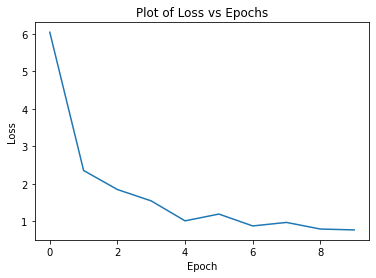

In [15]:
plt.plot(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Epochs')
plt.show()

### Load the best model (based on validation set) and evaluate on test set

In [16]:
model = load_model('./multilabel_train_seven_classes_xeno_canto/best.model')
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [17]:
prediction_dataset.df

,Toucan,Antshrike,Tody-Tyrant,Vireo,Kingbird,None,Antwren
file,,,,,,,
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_0.0s_3.0s.wav,0,0,1,0,0,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_3.0s_6.0s.wav,0,0,1,0,0,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_6.0s_9.0s.wav,0,0,1,0,0,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_9.0s_12.0s.wav,0,0,1,0,0,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_12.0s_15.0s.wav,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
./temp_clips/../Absent/20190705_171000_15.WAV,0,0,0,0,0,1,0
./temp_clips/../Absent/20190705_171000_16.WAV,0,0,0,0,0,1,0
./temp_clips/../Absent/20190705_171000_17.WAV,0,0,0,0,0,1,0


In [18]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=2,
                                                                 activation_layer='softmax')

(570, 7)


#### Print various metrics for the test set predictions

In [19]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       107
           1       0.00      0.00      0.00        25
           2       0.91      0.96      0.94        83
           3       0.95      0.95      0.95       102
           4       0.97      0.98      0.97        85
           5       1.00      0.94      0.97        66
           6       0.79      0.83      0.81       102

   micro avg       0.90      0.90      0.90       570
   macro avg       0.79      0.81      0.80       570
weighted avg       0.87      0.90      0.88       570
 samples avg       0.90      0.90      0.90       570



#### Plot the RIC curve and report AOC

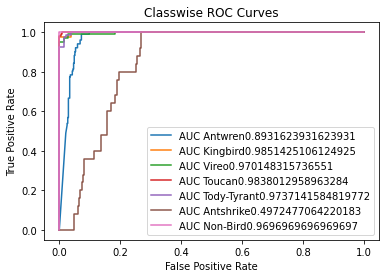

In [20]:
fpr, tpr, thresh = roc_curve(valid_labels_df['Antwren'],  valid_scores_df['Antwren'])
auc = roc_auc_score(valid_labels_df['Antwren'],  valid_preds_df['Antwren'])

fpr2, tpr2, thresh2 = roc_curve(valid_labels_df['Kingbird'],  valid_scores_df['Kingbird'])
auc2 = roc_auc_score(valid_labels_df['Kingbird'],  valid_preds_df['Kingbird'])

fpr3, tpr3, thresh3 = roc_curve(valid_labels_df['Vireo'],  valid_scores_df['Vireo'])
auc3 = roc_auc_score(valid_labels_df['Vireo'],  valid_preds_df['Vireo'])

fpr4, tpr4, thresh4 = roc_curve(valid_labels_df['Toucan'],  valid_scores_df['Toucan'])
auc4 = roc_auc_score(valid_labels_df['Toucan'],  valid_preds_df['Toucan'])

fpr5, tpr5, thresh5 = roc_curve(valid_labels_df['Tody-Tyrant'],  valid_scores_df['Tody-Tyrant'])
auc5 = roc_auc_score(valid_labels_df['Tody-Tyrant'],  valid_preds_df['Tody-Tyrant'])

fpr6, tpr6, thresh6 = roc_curve(valid_labels_df['Antshrike'],  valid_scores_df['Antshrike'])
auc6 = roc_auc_score(valid_labels_df['Antshrike'],  valid_preds_df['Antshrike'])

fpr7, tpr7, thresh7 = roc_curve(valid_labels_df['None'],  valid_scores_df['None'])
auc7 = roc_auc_score(valid_labels_df['None'],  valid_preds_df['None'])

plt.plot(fpr,tpr,label="AUC Antwren"+str(auc))
plt.plot(fpr2,tpr2,label="AUC Kingbird"+str(auc2))
plt.plot(fpr3,tpr3,label="AUC Vireo"+str(auc3))
plt.plot(fpr4,tpr4,label="AUC Toucan"+str(auc4))
plt.plot(fpr5,tpr5,label="AUC Tody-Tyrant"+str(auc5))
plt.plot(fpr6,tpr6,label="AUC Antshrike"+str(auc6))
plt.plot(fpr7,tpr7,label="AUC Non-Bird"+str(auc7))
plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()